## **Example. Stratified sampling in pre-election polling**

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

A survey of 1447 adults.

In [2]:
participants = 1447

This is the Table 8.2

In [3]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


We need the number of people of each region and each candidate.

In [4]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [5]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [6]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [7]:
valores = data_obs[:, :] * proportion.reshape(16, -1)
valores = np.round(valores)
np.sum(valores)   # Check if the sum is equal to 1447

1447.0

### **Nonhierarchical model**

In [8]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(valores, axis=1), p=thetas, observed=valores)

In [9]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

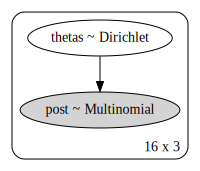

In [10]:
pm.model_to_graphviz(model_non_hiera)

In [11]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:13<00:00, 1165.84draws/s]


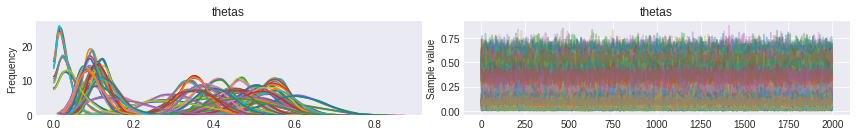

In [12]:
pm.traceplot(trace_1, varnames=['thetas']);

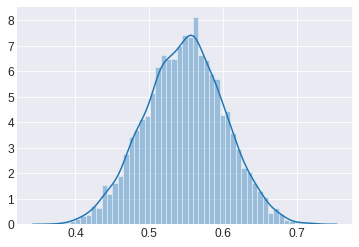

In [32]:
seaborn.distplot(trace_1['thetas'][:, 15, 0]);

In [33]:
pm.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetas__0_0,0.300100,0.065270,0.000467,0.180909,0.433704,19108.941028,0.999785
thetas__0_1,0.599518,0.068916,0.000470,0.467480,0.734045,19312.240459,0.999780
thetas__0_2,0.100383,0.041548,0.000308,0.030861,0.185469,16352.092254,0.999790
thetas__1_0,0.489750,0.070271,0.000530,0.355435,0.627806,20015.427544,0.999771
thetas__1_1,0.469661,0.070734,0.000520,0.329808,0.602264,18718.555274,0.999752
thetas__1_2,0.040589,0.027460,0.000211,0.001529,0.094604,15234.164792,0.999876
thetas__2_0,0.464979,0.037716,0.000300,0.395304,0.542023,17496.987976,0.999860
thetas__2_1,0.411825,0.037102,0.000292,0.340670,0.488188,18113.640211,0.999755
thetas__2_2,0.123196,0.024986,0.000189,0.075837,0.172040,17262.749166,0.999939
thetas__3_0,0.457686,0.057135,0.000413,0.344913,0.568706,18097.163950,1.000033


Now, the goal is to reproduce the figure 8.1 (a).

In [36]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, samples=1000, vars=[thetas, post])

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyError: packed_L

In [37]:
ppc_non_hiera['thetas'].shape

(1000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [38]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [39]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [40]:
diff = np.asarray(diff)
diff

array([[-0.33787199, -0.37379882, -0.25882127, ..., -0.24333032,
        -0.34828809, -0.2890644 ],
       [ 0.10464792, -0.0332341 ,  0.04314238, ..., -0.02677397,
         0.06811687, -0.02878468],
       [ 0.14668186, -0.09759919,  0.24836487, ..., -0.05777017,
         0.13984376, -0.02823006],
       ...,
       [ 0.17630032,  0.2639916 ,  0.08281504, ...,  0.12927367,
         0.12421466,  0.23584101],
       [ 0.10903527,  0.16980981,  0.1529897 , ...,  0.24074752,
         0.14888268,  0.18884677],
       [ 0.29177155,  0.00912029,  0.31554402, ...,  0.41702492,
         0.07311343,  0.33643738]])

In [41]:
res = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

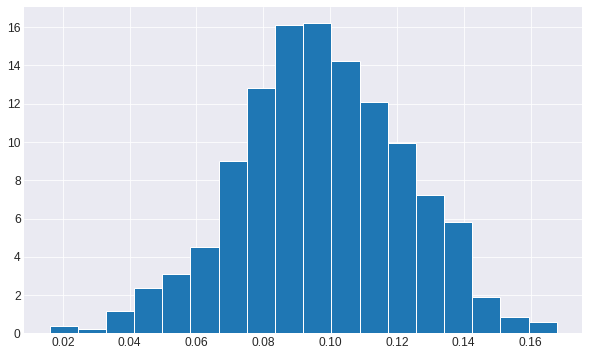

In [42]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res, bins=18, edgecolor='w', density=True)

**¡Se pudo reproducir la figura!**

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [43]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * data.proportion.to_numpy() * participants)
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [44]:
alpha_1j = valores[:, 0] / (valores[:, 0] + valores[:, 1]) * data.proportion.to_numpy() * participants
print(alpha_1j)

[ 15.07572093  23.66648889  88.29653061  32.68517647  20.94704762
  47.0275      65.67153846  89.73643411  14.47        51.16178571
  55.14501099 111.60316364  17.14475758  46.24016176  73.78419469
  49.9215    ]


In [45]:
new_values = np.round(np.stack([alpha_1j, alpha_2j], axis=1))
print(new_values)

[[ 15.  42.]
 [ 24.  45.]
 [ 88. 146.]
 [ 33.  68.]
 [ 21.  41.]
 [ 47.  84.]
 [ 66. 104.]
 [ 90. 129.]
 [ 14.  19.]
 [ 51.  84.]
 [ 55.  90.]
 [112. 165.]
 [ 17.  32.]
 [ 46.  68.]
 [ 74. 113.]
 [ 50.  76.]]


In [46]:
with pm.Model() as model_hier:
    
# #     rho = pm.Uniform('rho', lower=0, upper=1)
#     rho = pm.Normal('rho', mu=-0.5, sd=.2)
# #     mu = pm.Uniform('mu', lower=0, upper=50, shape=(2,))
#     mu = pm.HalfNormal('mu', sd=4, shape=(2,))
# #     mu2 = pm.HalfNormal('mu2', sd=1.4)
# #     tau = pm.Uniform('tau', lower=-2, upper=3, shape=(2,))
#     tau = pm.Beta('tau', alpha=2, beta=2, shape=(2,))
    
#     covariance = tt.stack([[tau[0]**2, rho * tau[0] * tau[1]], [rho * tau[0] * tau[1], tau[1]**2]], axis=1)
# #     print(covariance)
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(5))

    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', 0., 10., shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=(16, 2))
    
#     beta = pm.MvNormal('beta', mu=mu, cov=covariance, shape=2)
    
    alpha = pm.invlogit(beta)
#     alpha2 = pm.invlogit(beta[1])
    
    alphas = pm.Dirichlet('alphas', a=alpha, shape=(16, 2))
#     alphas = pm.Dirichlet('alphas', a=np.array([alpha1, alpha2]), shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alphas, observed=new_values)

In [47]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -3.91
mu                                -52.35
beta                              -29.41
alphas_stickbreaking__            -22.18
post                             -105.64
Name: Log-probability of test_point, dtype: float64

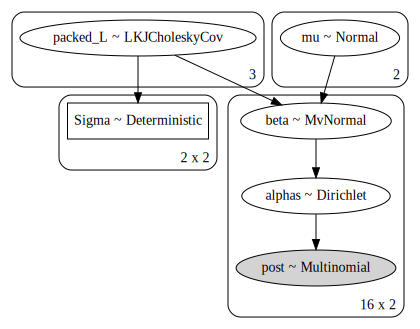

In [48]:
pm.model_to_graphviz(model_hier)

In [28]:
with model_hier:
    trace_2 = pm.sample(draws=2_000, tune=5_000, target_accept=0.90, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


KeyboardInterrupt: 

In [ ]:
pm.traceplot(trace_2, varnames=['beta']);

In [ ]:
pm.summary(trace_2, varnames=['alphas', 'mu'])

In [ ]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [ ]:
matrix_s

In [ ]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

In [ ]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [ ]:
rho

In [ ]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, samples=1000, vars=[alphas])

In [ ]:
ppc_hier['alphas'].shape

In [ ]:
valores[:, 0] / (valores[:, 0] + valores[:, 1])

In [ ]:
ppc_hier['alphas'][250, :, :]

In [ ]:
th1 = []

for i in range(16):
    result1 =  2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] - ppc_hier['alphas'][:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [ ]:
# print(th1

In [ ]:
th1 = np.asarray(th1)
th1.shape

In [ ]:
res2 = np.sum(th1.T * proportion / np.sum(proportion), axis=1)
res2[:15]

In [ ]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2 , bins=20, edgecolor='w', density=True)

In [49]:
%load_ext watermark

In [50]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.16.4
pymc3       3.6
pandas      0.24.2
arviz       0.4.1
seaborn     0.9.0
CPython 3.6.8
IPython 7.6.1

theano 1.0.4
scipy 1.3.0
matplotlib 3.1.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-55-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Intento con pystan

In [51]:
import pystan

In [52]:
modelo="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int y_obs[N, n];
  vector[n] alpha;
}

parameters {
  
  simplex[n] theta[N];
}

model {
  
  for (i in 1:N)
    theta[i] ~ dirichlet(alpha);
  
  for (i in 1:N)
    y_obs[i] ~ multinomial(theta[i]);
}

"""

In [53]:
stan_modelo = pystan.StanModel(model_code=modelo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a28c5090c429737936718a5aee45413 NOW.


In [54]:
data = {'N': 16,
       'n': 3,
       'alpha': [1,1,1],
       'y_obs': valores.astype(int)}

In [55]:
fit = stan_modelo.sampling(data=data)

In [56]:
print(fit.stansummary(digits_summary=5))

Inference for Stan model: anon_model_2a28c5090c429737936718a5aee45413.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]  0.3007  0.0006 0.0643 0.1805 0.2566 0.2987 0.3413 0.4357   8933 0.9995
theta[2,1]  0.4902  0.0008 0.0726 0.3454 0.4426 0.4907 0.5382 0.6296   7457 0.9997
theta[3,1]  0.4648  0.0003 0.0379 0.3918 0.4387 0.4640 0.4902 0.5415   9417 0.9995
theta[4,1]  0.4587  0.0006 0.0566 0.3484 0.4198 0.4589 0.4974 0.5708   7798 0.9993
theta[5,1]  0.4011  0.0007 0.0690 0.2691 0.3541 0.3999 0.4479 0.5394   9671 0.9993
theta[6,1]  0.4424  0.0005 0.0510 0.3418 0.4083 0.4422 0.4758 0.5441   8823 0.9992
theta[7,1]  0.5041  0.0005 0.0467 0.4125 0.4723 0.5041 0.5361 0.5958   8730 0.9993
theta[8,1]  0.5474  0.0004 0.0412 0.4684 0.5191 0.5470 0.5772 0.6272   7904 0.9992
theta[9,1]  0.5420  0.0011 0.0984 0.3488  0.474 0.5443 0.6117 0.

In [57]:
samples = fit.extract(permuted=True)['theta']

In [58]:
np.mean(samples[:, 0, 2])

0.10019681127543548

In [59]:
diff3 = []

for i in range(16):
    result3 = samples[:, i, 0] - samples[:, i, 1]
    diff3.append(list(result3))

In [60]:
diff3 = np.asarray(diff3)
diff3

array([[-0.23383337, -0.37255542, -0.49125213, ..., -0.212366  ,
        -0.14557615, -0.33563944],
       [-0.17927392,  0.08572703, -0.10061323, ...,  0.1241279 ,
        -0.20666601,  0.17206214],
       [ 0.14737479,  0.02937957,  0.17731195, ...,  0.16176922,
         0.12154819,  0.06636315],
       ...,
       [ 0.27727583,  0.20092786,  0.15775507, ...,  0.13165871,
         0.06343824, -0.05371965],
       [ 0.03499515,  0.14597643,  0.33526159, ...,  0.07464869,
         0.16823083,  0.21117046],
       [ 0.26470757,  0.37250208,  0.15273906, ...,  0.21898664,
         0.14903927,  0.1957518 ]])

In [61]:
res2 = np.sum(diff3.T * proportion / np.sum(proportion), axis=1)

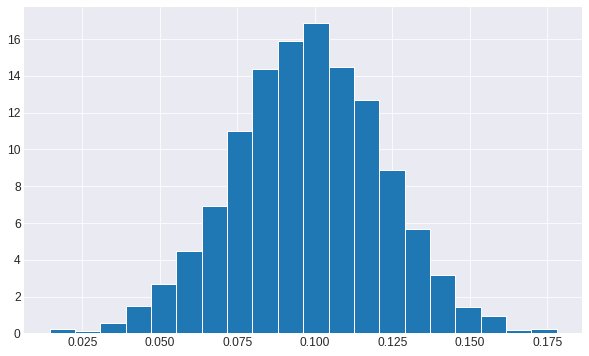

In [155]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2, bins=20, edgecolor='w', density=True)

## Ahora pystan con el modelo jerárquico

In [204]:
modelo2="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  simplex[n] alphas[N];
  vector[n] beta[N];
  
}

transformed parameters{
  
  vector[n] theta[N];
  
  for (i in 1:N)
    theta[i] = inv_logit(beta[i]);
    
   
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ cauchy(0, 5);
  
  beta ~ multi_normal_cholesky(mu, L);
  
  
  for (i in 1:N)
    alphas[i] ~ dirichlet(theta[i]);
    
  for (i in 1:N)
    post[i] ~ multinomial(alphas[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}


"""

In [205]:
stan_modelo2 = pystan.StanModel(model_code=modelo2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_958bb8552d6652a8814e6044bd42f4a8 NOW.


In [206]:
data2 = {'N': 16,
         'n': 2,
         'post': new_values.astype(int)}

In [207]:
fit2 = stan_modelo2.sampling(data=data2, algorithm='HMC', iter=4000, verbose=True)

In [210]:
print(fit2.stansummary(digits_summary=5))

Inference for Stan model: anon_model_958bb8552d6652a8814e6044bd42f4a8.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       2.2705e1  8.01884.6381e1 1.1962 3.6407 7.20241.7178e11.7396e2     33 1.1352
mu[2]       2.0993e1  4.87353.433e1 2.2160 4.9229 8.72791.931e11.4692e2     50 1.0651
L[1,1]          1.0     nan    0.0    1.0    1.0    1.0    1.0    1.0    nan    nan
L[2,1]       -0.000  0.0056 0.3769 -0.709 -0.275 0.0006 0.2848 0.7012   4423 0.9999
L[1,2]          0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan
L[2,2]       0.9210  0.0023 0.0976 0.6453 0.8878 0.9600 0.9904 0.9999   1741 1.0020
alphas[1,1]  0.2707  0.0002 0.0572 0.1649 0.2311 0.2686 0.3065 0.3915  39793 0.9996
alphas[2,1]   0.352  0.0006 0.0556 0.2468 0.3122 0.3519 0.3904 0.4620   8197 0.9998
alphas[3,1]  0.3770  0.0001 0.0308 0.3166 0.3565 

In [211]:
samples2 = fit2.extract(permuted=True)['alphas']

In [217]:
np.mean(samples2[:, 15, 1])

0.6020207893922684

In [218]:
th5 = []

for i in range(16):
    result5 =  2 * samples2[:, i, 0] * samples2[:, i, 1] - samples2[:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th5.append(list(result5))

In [220]:
th5 = np.asarray(th5)
th5.shape

(16, 8000)

In [221]:
res5 = np.sum(th5.T * proportion / np.sum(proportion), axis=1)
res5[:15]

array([-0.15178621, -0.15164549, -0.11995138, -0.1770054 , -0.14536233,
       -0.13756777, -0.14771482, -0.15834537, -0.15584203, -0.13804698,
       -0.14927179, -0.12890647, -0.15400477, -0.12556515, -0.13719998])

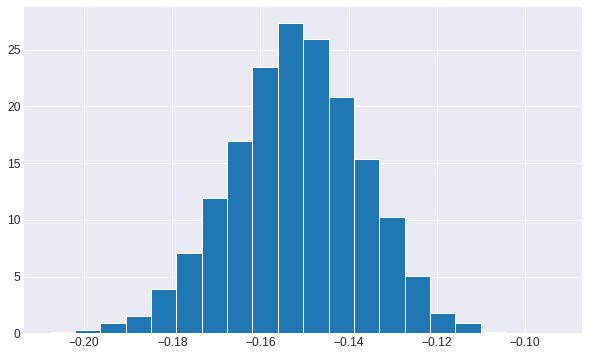

In [224]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res5 , bins=20, edgecolor='w', density=True)

In [168]:
new_values[:7,]

array([[ 15.,  42.],
       [ 24.,  45.],
       [ 88., 146.],
       [ 33.,  68.],
       [ 21.,  41.],
       [ 47.,  84.],
       [ 66., 104.]])